
# **Initiate and Configure Spark**

In [1]:
!pip3 install pyspark
!pip3 install xgboost

In [2]:
# Launch Session
from pyspark.sql import SparkSession
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from xgboost.spark import SparkXGBRegressor
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, first, when, lit, avg, count, lag, lead, max as spark_max, rand
from pyspark.sql import functions as F
from pyspark.sql.window import Window

spark = SparkSession.builder \
                    .appName("IPL Prediction_spark") \
                    .master("local[*]") \
                    .config("spark.executor.memory", "4g") \
                    .config("spark.driver.memory", "2g") \
                    .config("spark.executor.cores", "2") \
                    .config("spark.sql.inMemoryColumnarStorage.compressed", "true") \
                    .getOrCreate()

spark


## **Data Loading and Preprocessing**


Data Link : https://www.kaggle.com/datasets/ramjidoolla/ipl-data-set

In [3]:

# Both students go with same datasets
# Access matches Data
matches = spark.read.csv("/content/matches.csv", header=True,
                         inferSchema=True)
print("Amount of Info:",matches.count())
# This method transfors matches DF into an rdd(Resilient Disributed Dataset),That is a lower-level spark simplicication
print("Divisions of Info",matches.rdd.getNumPartitions())


# Acess the deliveries Data
deliveries = spark.read.csv("/content/deliveries.csv", header=True,
                            inferSchema=True)
print("Amount of Info:",deliveries.count())

# This method transfors the deliveries DF into an rdd(Resilient Disributed Dataset),That is a lower-level spark simplicication
print("Divisions of Info:",deliveries.rdd.getNumPartitions())

Amount of Info: 756
Divisions of Info 1
Amount of Info: 179078
Divisions of Info: 2


In [4]:
# Display some rows
matches.show(5)

+---+--------+---------+----------+--------------------+--------------------+--------------------+-------------+------+----------+--------------------+-----------+--------------+---------------+--------------------+--------------+-------------+-------+
| id|  Season|     city|      date|               team1|               team2|         toss_winner|toss_decision|result|dl_applied|              winner|win_by_runs|win_by_wickets|player_of_match|               venue|       umpire1|      umpire2|umpire3|
+---+--------+---------+----------+--------------------+--------------------+--------------------+-------------+------+----------+--------------------+-----------+--------------+---------------+--------------------+--------------+-------------+-------+
|  1|IPL-2017|Hyderabad|05-04-2017| Sunrisers Hyderabad|Royal Challengers...|Royal Challengers...|        field|normal|         0| Sunrisers Hyderabad|         35|             0|   Yuvraj Singh|Rajiv Gandhi Inte...|   AY Dandekar|     NJ Llo

In [5]:
# Display some rows
deliveries.show(5)

+--------+------+-------------------+--------------------+----+----+---------+-----------+--------+-------------+---------+--------+-----------+-----------+------------+------------+----------+----------+----------------+--------------+-------+
|match_id|inning|       batting_team|        bowling_team|over|ball|  batsman|non_striker|  bowler|is_super_over|wide_runs|bye_runs|legbye_runs|noball_runs|penalty_runs|batsman_runs|extra_runs|total_runs|player_dismissed|dismissal_kind|fielder|
+--------+------+-------------------+--------------------+----+----+---------+-----------+--------+-------------+---------+--------+-----------+-----------+------------+------------+----------+----------+----------------+--------------+-------+
|       1|     1|Sunrisers Hyderabad|Royal Challengers...|   1|   1|DA Warner|   S Dhawan|TS Mills|            0|        0|       0|          0|          0|           0|           0|         0|         0|            NULL|          NULL|   NULL|
|       1|     1|Sun

In [6]:
# Visualize the Headers of the datasets
print("Deliveries Columns:", deliveries.columns)
print("Matches Columns:", matches.columns)

Deliveries Columns: ['match_id', 'inning', 'batting_team', 'bowling_team', 'over', 'ball', 'batsman', 'non_striker', 'bowler', 'is_super_over', 'wide_runs', 'bye_runs', 'legbye_runs', 'noball_runs', 'penalty_runs', 'batsman_runs', 'extra_runs', 'total_runs', 'player_dismissed', 'dismissal_kind', 'fielder']
Matches Columns: ['id', 'Season', 'city', 'date', 'team1', 'team2', 'toss_winner', 'toss_decision', 'result', 'dl_applied', 'winner', 'win_by_runs', 'win_by_wickets', 'player_of_match', 'venue', 'umpire1', 'umpire2', 'umpire3']


In [7]:
# paired deliveries with matches dataset
paired_data = deliveries.join(
    matches,
    deliveries.match_id == matches.id,
    "left"  # Using left join can maintain all rows from deliveries
)

# Select all columns from deliveries plus needed cols from matches
# Here we can see the selected cols from matches
paired_deliveries = paired_data.select(
    "match_id","inning","batting_team","bowling_team","over","ball","batsman",
    "non_striker","bowler","is_super_over","wide_runs","bye_runs","legbye_runs",
    "noball_runs","penalty_runs","batsman_runs","extra_runs","total_runs","player_dismissed",
    "dismissal_kind","fielder",

# Rest of Other Col from matches dataset
    matches.Season,
    matches.city,
    matches.venue,
    matches.winner,
    matches.toss_winner
)

# Check the Data from linked dataset
print("No.of rows in the Joined Dataset: ",paired_deliveries.count())
print("Count of the Joined Dataset",len(paired_deliveries.columns))

No.of rows in the Joined Dataset:  179078
Count of the Joined Dataset 26


In [8]:
# Declared the data for the further use in the code
xgb_regressor_data = paired_data

In [9]:
# Remove the Col that having huge number of missing values
xgb_regressor_data = xgb_regressor_data.drop("player_dismissed")
xgb_regressor_data = xgb_regressor_data.drop("dismissal_kind")
xgb_regressor_data = xgb_regressor_data.drop("fielder")
xgb_regressor_data = xgb_regressor_data.drop("umpire3")

In [11]:
# Searching for the missing values before model Training
from pyspark.sql.functions import col, sum

# Choosing Col for measuring the null values
missing_values = xgb_regressor_data.select([sum(col(c).isNull().cast("int")).alias(c) for c in xgb_regressor_data.columns])

# Displaying Null values
missing_values.show()

+--------+------+------------+------------+----+----+-------+-----------+------+-------------+---------+--------+-----------+-----------+------------+------------+----------+----------+---+------+----+----+-----+-----+-----------+-------------+------+----------+------+-----------+--------------+---------------+-----+-------+-------+
|match_id|inning|batting_team|bowling_team|over|ball|batsman|non_striker|bowler|is_super_over|wide_runs|bye_runs|legbye_runs|noball_runs|penalty_runs|batsman_runs|extra_runs|total_runs| id|Season|city|date|team1|team2|toss_winner|toss_decision|result|dl_applied|winner|win_by_runs|win_by_wickets|player_of_match|venue|umpire1|umpire2|
+--------+------+------------+------------+----+----+-------+-----------+------+-------------+---------+--------+-----------+-----------+------------+------------+----------+----------+---+------+----+----+-----+-----+-----------+-------------+------+----------+------+-----------+--------------+---------------+-----+-------+----

In [12]:
# Print the Schema of the linked Data
xgb_regressor_data.printSchema()

root
 |-- match_id: integer (nullable = true)
 |-- inning: integer (nullable = true)
 |-- batting_team: string (nullable = true)
 |-- bowling_team: string (nullable = true)
 |-- over: integer (nullable = true)
 |-- ball: integer (nullable = true)
 |-- batsman: string (nullable = true)
 |-- non_striker: string (nullable = true)
 |-- bowler: string (nullable = true)
 |-- is_super_over: integer (nullable = true)
 |-- wide_runs: integer (nullable = true)
 |-- bye_runs: integer (nullable = true)
 |-- legbye_runs: integer (nullable = true)
 |-- noball_runs: integer (nullable = true)
 |-- penalty_runs: integer (nullable = true)
 |-- batsman_runs: integer (nullable = true)
 |-- extra_runs: integer (nullable = true)
 |-- total_runs: integer (nullable = true)
 |-- id: integer (nullable = true)
 |-- Season: string (nullable = true)
 |-- city: string (nullable = true)
 |-- date: string (nullable = true)
 |-- team1: string (nullable = true)
 |-- team2: string (nullable = true)
 |-- toss_winner: str

In [ ]:
# Convert columns to double for ML Adaptability
from pyspark.sql.functions import col

# Loop through each pass
for column in xgb_regressor_data.columns:
  xgb_regressor_data = xgb_regressor_data.withColumn(column, col(column).cast("double")) # Casting Each Col

# Displaying the 1st row after the Each casting
  xgb_regressor_data.show(1)

  VECTOR ASSEMBLER

In [14]:
# A (VA) was used to make the multiple selected features into isolated Instance
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols = ["match_id","inning", "over","ball",
                                         "batsman_runs", "extra_runs"],
                            outputCol = "features")

d_info = assembler.transform(deliveries)
d_info = d_info.select("features", "total_runs")


In [15]:
d_info.show(5, truncate = False)

+-------------------------+----------+
|features                 |total_runs|
+-------------------------+----------+
|[1.0,1.0,1.0,1.0,0.0,0.0]|0         |
|[1.0,1.0,1.0,2.0,0.0,0.0]|0         |
|[1.0,1.0,1.0,3.0,4.0,0.0]|4         |
|[1.0,1.0,1.0,4.0,0.0,0.0]|0         |
|[1.0,1.0,1.0,5.0,0.0,2.0]|2         |
+-------------------------+----------+
only showing top 5 rows



In [16]:
# Function to count nulls for each column
def count_nulls(df):
    from pyspark.sql.functions import col, count, isnan, when

    # Tally null and NaN items from every col
    null_counts = []
    total_rows = df.count()

    for column in df.columns:
        null_count = df.filter(
            col(column).isNull() |
            isnan(col(column)) |
            (col(column) == "")
        ).count()

        no_val_per = (null_count / total_rows) * 100 if total_rows > 0 else 0
        null_counts.append((column, null_count, no_val_per))

    # Create a DataFrame with the results
    null_df = spark.createDataFrame(
        null_counts,
        ["Column", "Null Count", "Null Percentage"]
    )

    return null_df.orderBy("Null Count", ascending=False)

# Check for nulls in the combined dataset
null_analysis = count_nulls(paired_data)
null_analysis.show(40, truncate=False)  # Show all columns

+----------------+----------+-------------------+
|Column          |Null Count|Null Percentage    |
+----------------+----------+-------------------+
|fielder         |172630    |96.3993343682641   |
|player_dismissed|170244    |95.06695406470924  |
|dismissal_kind  |170244    |95.06695406470924  |
|umpire3         |150712    |84.15997498296831  |
|city            |1700      |0.9493070058857035 |
|umpire1         |500       |0.27920794290755985|
|umpire2         |500       |0.27920794290755985|
|winner          |372       |0.20773070952322453|
|player_of_match |372       |0.20773070952322453|
|match_id        |0         |0.0                |
|id              |0         |0.0                |
|inning          |0         |0.0                |
|Season          |0         |0.0                |
|batting_team    |0         |0.0                |
|date            |0         |0.0                |
|bowling_team    |0         |0.0                |
|team1           |0         |0.0                |


---
# **Model Selection and Implementation**
---


In [17]:
# Divide content into Train & Test.
# Here the Information was divided to 70% of the data used for training and 30% for searching.
# Randomsplit was used to seperate the content randomly.
trained_data, tested_data = d_info.randomSplit([0.7, 0.3], seed = 134)

# Visualize the trained_data
trained_data.show(5, truncate= False)

# Visualize the count(Trained and Tested) content.
print("Count of the Trained Data:", trained_data.count())
print("Count of the Tested Data:", tested_data.count())

+-------------------------+----------+
|features                 |total_runs|
+-------------------------+----------+
|[1.0,1.0,1.0,1.0,0.0,0.0]|0         |
|[1.0,1.0,1.0,2.0,0.0,0.0]|0         |
|[1.0,1.0,1.0,3.0,4.0,0.0]|4         |
|[1.0,1.0,1.0,5.0,0.0,2.0]|2         |
|[1.0,1.0,1.0,6.0,0.0,0.0]|0         |
+-------------------------+----------+
only showing top 5 rows

Count of the Trained Data: 125361
Count of the Tested Data: 53717


In [ ]:
 #XGBoost Regressor
# Import the Regressor from spark
from xgboost.spark import SparkXGBRegressor

# Define Features
xgb_regressor = SparkXGBRegressor(
    features_col="features",      # Input Features
    label_col="total_runs"        # Target Column
)

#Training to xgb_model with the help of trained_data
xgb_mod = xgb_regressor.fit(trained_data)

# Using trained xgb model for the predictions
xgb_pred = xgb_mod.transform(tested_data)


In [19]:
# showcase the predictions from the selected data(total_runs and prediction)
xgb_pred.select("total_runs", "prediction").show(10, truncate=False)

+----------+--------------------+
|total_runs|prediction          |
+----------+--------------------+
|0         |3.443599098318373E-6|
|4         |3.9999966621398926  |
|1         |0.9999969601631165  |
|0         |3.443599098318373E-6|
|0         |3.443599098318373E-6|
|3         |3.0000038146972656  |
|1         |1.0000003576278687  |
|1         |1.0000003576278687  |
|1         |1.0000003576278687  |
|1         |1.0000003576278687  |
+----------+--------------------+
only showing top 10 rows



---
# **Model Parameter Tuning**
---


In [ ]:
# Importing the packages of the ParamGridBuilder and CrossValidation for the Model Tuning
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
# ParamGrid is used to allows the analysis the multiple mixtures of parameter to search the best achieving model
param_grid = (ParamGridBuilder()
      .addGrid(xgb_regressor.max_depth, [3, 5, 9]) # Max dept of a tree
      .addGrid(xgb_regressor.learning_rate, [0.02, 0.6, 0.1]) # Step Size
      .addGrid(xgb_regressor.n_estimators, [100, 150, 300]) # No.of Boosting Rounds
      .addGrid(xgb_regressor.subsample, [0.5, 0.4, 0.8]) # Fraction of samples used for each boosting round
      .addGrid(xgb_regressor.colsample_bytree, [0.3, 0.7, 0.9]) # Features used in each Tree
      .build())

# Evalutor
evaluator = RegressionEvaluator(labelCol="total_runs",
                                predictionCol="prediction",metricName="rmse")

# To avoiding the Overfitting and Tuning the Hyperparameters
# Cross Validation
cvalid = CrossValidator(
      estimator=xgb_regressor,
      estimatorParamMaps=param_grid,
      evaluator=evaluator,
      numFolds=3  # Validation using 3 data partitions
  )

# Traning model
CVal_mod = cvalid.fit(trained_data)

# Get xgb model
xgb_mod = CVal_mod.bestModel

In [21]:
# Model outputs after Tuning
xgb_pred = xgb_mod.transform(tested_data)

# Predictions of the selected features after the Model Tuning and show the predictions
xgb_pred.select("total_runs", "prediction")
xgb_pred.show(10)

+--------------------+----------+--------------------+
|            features|total_runs|          prediction|
+--------------------+----------+--------------------+
|[1.0,1.0,1.0,4.0,...|         0|1.947926830325741...|
|[1.0,1.0,2.0,2.0,...|         4|   4.000034332275391|
|[1.0,1.0,2.0,3.0,...|         1|   1.000022053718567|
|[1.0,1.0,3.0,2.0,...|         0| 3.21356019412633E-5|
|[1.0,1.0,3.0,3.0,...|         0|3.316983566037379E-5|
|[1.0,1.0,3.0,4.0,...|         3|  3.0000808238983154|
|[1.0,1.0,3.0,6.0,...|         1|  1.0000289678573608|
|[1.0,1.0,4.0,2.0,...|         1|   1.000028133392334|
|[1.0,1.0,5.0,1.0,...|         1|  1.0000073909759521|
|[1.0,1.0,5.0,2.0,...|         1|  1.0000098943710327|
+--------------------+----------+--------------------+
only showing top 10 rows



In [22]:
# Laaso
from pyspark.ml.regression import LinearRegression

# Define the Features for Lasso Reg
ls_reg = LinearRegression(featuresCol = 'features',
                      labelCol = 'total_runs',
                      elasticNetParam = 1.0,
                      regParam = 0.17)

# Training the Lasso using the trained_data
lsr_mod = ls_reg.fit(trained_data)

# Using the model make the predictions
lsr_pred = lsr_mod.transform(tested_data)

# Ridge
# Define the Features for Ridge Regression
rd_reg = LinearRegression(featuresCol = 'features',labelCol = 'total_runs',
                         predictionCol = 'prediction', elasticNetParam = 0.0, regParam = 0.15)
rid_mod = rd_reg.fit(trained_data)
rid_pred = rid_mod.transform(tested_data)

In [23]:
# Visualize from Lasso Regression model
lsr_pred.select("total_runs", "prediction").show(10)

+----------+-------------------+
|total_runs|         prediction|
+----------+-------------------+
|         0|0.18662554749301596|
|         4|  3.708414198846322|
|         1| 0.6215678673087217|
|         0|0.18662554749301596|
|         0|0.18662554749301596|
|         3| 2.8279670360079954|
|         1| 1.0670727103313424|
|         1| 1.0670727103313424|
|         1| 1.0670727103313424|
|         1| 1.0670727103313424|
+----------+-------------------+
only showing top 10 rows



In [24]:
# Visualize the predictions from Ridge Regression model
rid_pred.select("total_runs","prediction").show(10)

+----------+-------------------+
|total_runs|         prediction|
+----------+-------------------+
|         0|0.10040234981290896|
|         4| 3.7451322091578083|
|         1| 0.9718312838669817|
|         0|0.10317872265836195|
|         0|0.10377189663448028|
|         3|  2.837316205784317|
|         1| 1.0165351302874082|
|         1| 1.0161437947817797|
|         1|  1.017531981204506|
|         1| 1.0181251551806245|
+----------+-------------------+
only showing top 10 rows



---
# **Task 4 - Model Evaluation and Accuracy Calculation (20 marks)**
---

In [25]:
##1st student name: Bhargav Mouli G
# Metrics for the Different Regression Models
from pyspark.ml.evaluation import RegressionEvaluator

# Evalute the mse
evaluation_mse = RegressionEvaluator(labelCol = 'total_runs',
                                    predictionCol = 'prediction', metricName = 'mse')
# Compute mse
xgb_mse = evaluation_mse.evaluate(xgb_pred)
l_mse = evaluation_mse.evaluate(lsr_pred)
R_mse = evaluation_mse.evaluate(rid_pred)

# Evalute the rmse
evaluation_rmse = RegressionEvaluator(labelCol = "total_runs",
                                     predictionCol = "prediction",metricName = "rmse")
# compute rmse
xgb_rmse = evaluation_rmse.evaluate(xgb_pred)
l_rmse = evaluation_rmse.evaluate(lsr_pred)
R_rmse = evaluation_rmse.evaluate(rid_pred)

# Evalute the R^2
evaluation_r2 = RegressionEvaluator(labelCol = 'total_runs',
                                   predictionCol = 'prediction', metricName = 'r2')
# compute R^2
xgb_r2_score = evaluation_r2.evaluate(xgb_pred)
l_r2_score = evaluation_r2.evaluate(lsr_pred)
R_r2_score = evaluation_mse.evaluate(rid_pred)


In [26]:
print("XGBoost Regressor Metrics")
print("xg :mse",xgb_mse)
print("xg :rmse",xgb_rmse)
print("xg :r^2",xgb_r2_score)

XGBoost Regressor Metrics
xg :mse 6.678887794880812e-10
xg :rmse 2.5843544251671078e-05
xg :r^2 0.9999999997409574


In [27]:
#Lasso Metrics
print("Lasso Regression Metrics")
print("lr :mse",l_mse)
print("lr :rmse",l_rmse)
print("lr :r^2",l_r2_score)

Lasso Regression Metrics
lr :mse 0.06704338018755755
lr :rmse 0.25892736469434346
lr :r^2 0.9739970317218983


In [28]:
print("Ridge Regression Metrics")
print("rr :mse",R_mse)
print("rr :rmse",R_rmse)
print("rr :r^2",R_r2_score)

Ridge Regression Metrics
rr :mse 0.020897669330054013
rr :rmse 0.144560261932711
rr :r^2 0.020897669330054013


---
# **Task 5 - Results Visualization or Printing (5 marks)**
---

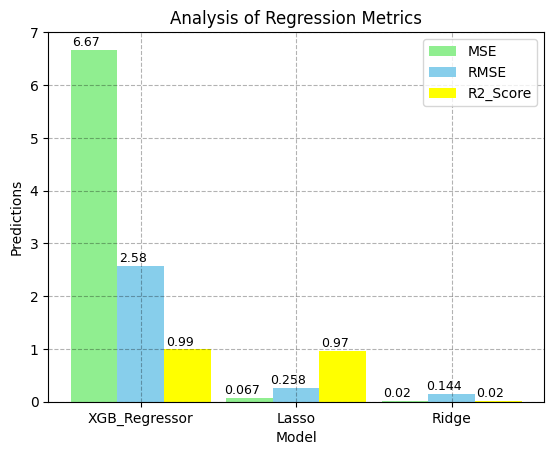

In [29]:
##Student 1 : Bhargav Mouli G
# Importing the packages to Showcase
import matplotlib.pyplot as plt
import numpy as np

mse = [6.67,0.067,0.02]
rmse = [2.58, 0.258, 0.144]
r2_score = [0.99, 0.97, 0.020]

pos = np.arange(len(mse))
bars_width = 0.3

# Customizing the Bar
b1 = plt.bar(pos - bars_width, mse, width = bars_width, label = 'MSE',color="lightgreen")
b2 = plt.bar(pos, rmse, width = bars_width, label = 'RMSE',color="skyblue")
b3 = plt.bar(pos + bars_width, r2_score, width = bars_width, label = 'R2_Score',color="yellow")

for bar_group in [b1, b2, b3]:
    for block in bar_group:
        height = block.get_height()
        plt.text(block.get_x() + block.get_width()/3.0, height + 0.02, str(height),
                 ha='center', va='bottom', fontsize=9)

# Specifying title, labels
plt.xlabel('Model')
plt.ylabel('Predictions')
plt.title('Analysis of Regression Metrics')

# Background grid
plt.grid(True, color='Black', linestyle='--', alpha=0.3)

# Attaching the legend
plt.legend()
plt.xticks(pos, ['XGB_Regressor', 'Lasso','Ridge'])
plt.show()

In [ ]:
# install nbconvert (if facing the conversion error)
!pip3 install nbconvert

In [ ]:
# convert ipynb to html and submit this HTML file
!jupyter nbconvert --to html Group_21_CRWK_CN7030.ipynb

[NbConvertApp] Converting notebook Group_21_CRWK_CN7030.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Writing 578411 bytes to Group_21_CRWK_CN7030.html
